In [14]:
# Adding HUGS and Acquire to the Python path
import sys
import os
sys.path.insert(0, os.path.abspath("../.."))

# Searching the object store

In this example we will load in data from 3 sites. The data will be separated into sections and stored in the object store. We can then use a search function to search for data from the sites over a certain daterange, retrieve that data and visualize it.

In [13]:
from HUGS.Modules import CRDS, Datasource
from HUGS.ObjectStore import get_local_bucket, get_object_names
from HUGS.Processing import recombine_sections, search
from HUGS.Util import get_datetime
# Matplotlib for inline plotting
%matplotlib notebook
import matplotlib.pyplot as plt
# Suppress matplotlib and pandas warning on deprecation
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
# Pretty printer for nicer printing to console
import pprint
pp = pprint.PrettyPrinter(indent=2)


First we get an empty bucket to store the data we are going to process. We then use the CRDS static method `read_folder`. This reads all `*.dat` files in a folder and passes them to `CRDS.read_file` for processing.

In [3]:
bucket = get_local_bucket(empty=True)
test_data = "../../test/data/search_data/"

os.listdir(test_data)


['hfd.picarro.1minute.100m.min.dat',
 'tac.picarro.1minute.100m.min.dat',
 'bsd.picarro.1minute.108m.min.dat']

In [4]:
CRDS.read_folder(folder_path=test_data)

In [5]:
prefix = "datasource"
objects_in_store = get_object_names(bucket=bucket, prefix=prefix)

We can now list all the objects that have been created and stored in the object store

In [6]:
pp.pprint(objects_in_store)

[ 'datasource/uuid/1cd70cb4-e4c8-4ed3-8254-34ccc13974c4',
  'datasource/uuid/b65d822d-524c-4e7d-ae9c-2eb9de16cad4',
  'datasource/uuid/48bee4c7-163b-4132-b361-73d520d1f637',
  'datasource/uuid/61ad51ce-8450-414c-bbcc-95cd8add1d3b',
  'datasource/uuid/1a378b12-9b18-49da-939e-9633ad2e43c5',
  'datasource/uuid/e7a2d447-ba6c-463a-9cb6-ed6eb524f287',
  'datasource/uuid/7aaeb8ae-de4c-49b0-88af-3919dfd66758',
  'datasource/uuid/2f97e73c-ff03-4fd7-8926-60f8d90c655f']


To search the data we search the label dictionary that is stored within each Datasource. To do this we load in the Datasources using the keys obtained from `get_object_names` and store these objects in a list. Note: we pass in `shallow=True` here to stop each Datasource loading in its data, we only require the JSON data that makes up the `name`, `uuid`, `labels` etc of the object

In [7]:
datasources = [Datasource.load(key=key) for key in objects_in_store]
pp.pprint(datasources)

[ <HUGS.Modules._datasource.Datasource object at 0x7fee5467f940>,


We can now create a list of search terms to be passed to the search function.

In [8]:
search_terms = ["bsd", "hfd", "tac"]

We must also provide the data type we are searching for and can optionally provide a start and end datetime for our search

In [9]:
data_type = "CRDS"
start = get_datetime(year=2014, month=1, day=1)
end = get_datetime(year=2016, month=1, day=1)

In [17]:
results = search(search_terms=search_terms, data_type=data_type, require_all=False, start_datetime=start, end_datetime=end)

for key, value in sorted(results.items()):
    print(key, ":", value, "\n")

bsd_ch4 : ['data/uuid/2f97e73c-ff03-4fd7-8926-60f8d90c655f/2015-01-01T00:33:30_2015-10-24T08:57:30', 'data/uuid/2f97e73c-ff03-4fd7-8926-60f8d90c655f/2014-01-30T13:33:30_2014-12-31T22:23:30'] 

bsd_co : ['data/uuid/7aaeb8ae-de4c-49b0-88af-3919dfd66758/2015-01-01T00:33:30_2015-10-24T08:57:30', 'data/uuid/7aaeb8ae-de4c-49b0-88af-3919dfd66758/2014-01-30T13:33:30_2014-12-31T22:23:30'] 

bsd_co2 : ['data/uuid/48bee4c7-163b-4132-b361-73d520d1f637/2015-01-01T00:33:30_2015-10-24T08:57:30', 'data/uuid/48bee4c7-163b-4132-b361-73d520d1f637/2014-01-30T13:33:30_2014-12-31T22:23:30'] 

hfd_ch4 : ['data/uuid/1cd70cb4-e4c8-4ed3-8254-34ccc13974c4/2015-01-01T00:42:30_2015-12-31T21:31:30', 'data/uuid/1cd70cb4-e4c8-4ed3-8254-34ccc13974c4/2014-01-01T02:01:30_2014-12-31T21:32:30'] 

hfd_co : ['data/uuid/61ad51ce-8450-414c-bbcc-95cd8add1d3b/2015-01-01T00:42:30_2015-12-31T21:31:30', 'data/uuid/61ad51ce-8450-414c-bbcc-95cd8add1d3b/2014-01-01T02:01:30_2014-12-31T21:32:30'] 

hfd_co2 : ['data/uuid/1a378b12-9b18-4

The search function returns a Python dictionary that is keyed using the search term and the species name
as `search_term_species_name`. The value part of the key:value pair consists of object store keys that point to the raw data stored in the HDF5 format in the object store.

The dictionary can be see as so

`bsd_ch4 : ['data/uuid/db5cbe8b-a66e-45dc-bba4-8b79eb61e261/2015-01-01T00:33:30_2015-10-24T08:57:30', 'data/uuid/db5cbe8b-a66e-45dc-bba4-8b79eb61e261/2014-01-30T13:33:30_2014-12-31T22:23:30']`

where the key is formed of `bsd` (the Bilsdale site) and `ch4` (the name of the species) and the value part containing object store keys in the form `data/uuid/{uuid_here}`.

We now pass this dictionary to the `recombine_sections` function that retrieves the data stored in the object store keys and joins the sections as per the keying in the dictionary.

In [11]:
recombined_sections = recombine_sections(data_keys=results)

We can now plot the methane readings from each site for comparison

<IPython.core.display.Javascript object>


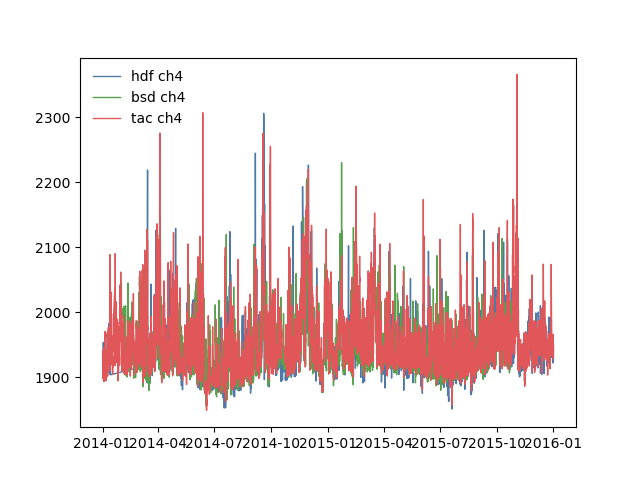

In [12]:
hdf_ch4 = recombined_sections["hfd_ch4"]
bsd_ch4 = recombined_sections["bsd_ch4"]
tac_ch4 = recombined_sections["tac_ch4"]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(hdf_ch4.index.values, hdf_ch4["ch4 count"], label = "hdf ch4", linewidth = 1, color="#4e79a7")
ax.plot(bsd_ch4.index.values, bsd_ch4["ch4 count"], label = "bsd ch4", linewidth = 1, color="#59a14f")
ax.plot(tac_ch4.index.values, tac_ch4["ch4 count"], label = "tac ch4", linewidth = 1, color="#e15759")
ax.legend(frameon=False)